# **Plant Disease Predictor**

# Required Libraries


In [ ]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
import tensorflow
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
# from keras.preprocessing.image import img_to_array
from keras_preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
DEFAULT_IMAGE_SIZE = tuple((256, 256))
N_IMAGES = 100
root_dir = './PDD'
train_dir = os.path.join(root_dir, 'PlantVillage')


In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")


np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed

Total number of images: 1500


Examine the labels/classes in the training dataset.

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  15


# Augmentation and Splitting of Dataset

In [ ]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2,
                             zoom_range=0.2, horizontal_flip=True,
                             fill_mode="nearest")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Splitting data to train and test...


# Build Model


In [ ]:
EPOCHS = 25
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

In [ ]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

# Train Model


In [ ]:
opt = Adam(lr=LR, decay=LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] Training network...")
history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS,
                              verbose=1)

[INFO] Training network...


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-13-6d88faf22259>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),


Epoch 1/25
37/37 [==============================] - 28s 514ms/step - loss: 0.7745 - accuracy: 0.2038 - val_loss: 0.6366 - val_accuracy: 0.0700
Epoch 2/25
37/37 [==============================] - 16s 431ms/step - loss: 0.4660 - accuracy: 0.2962 - val_loss: 0.5467 - val_accuracy: 0.1233
Epoch 3/25
37/37 [==============================] - 16s 422ms/step - loss: 0.3696 - accuracy: 0.2483 - val_loss: 0.4723 - val_accuracy: 0.1033
Epoch 4/25
37/37 [==============================] - 16s 427ms/step - loss: 0.2612 - accuracy: 0.3476 - val_loss: 0.6840 - val_accuracy: 0.1067
Epoch 5/25
37/37 [==============================] - 16s 428ms/step - loss: 0.2120 - accuracy: 0.4743 - val_loss: 0.8022 - val_accuracy: 0.0933
Epoch 6/25
37/37 [==============================] - 16s 431ms/step - loss: 0.1788 - accuracy: 0.5574 - val_loss: 0.8510 - val_accuracy: 0.0733
Epoch 7/25
37/37 [==============================] - 16s 431ms/step - loss: 0.1646 - accuracy: 0.5873 - val_loss: 0.8329 - val_accuracy: 0.1000

# Evaluate Model

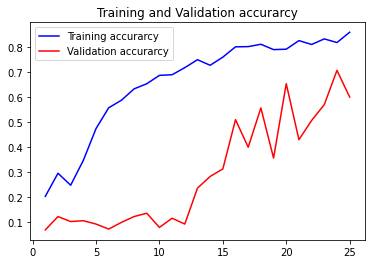

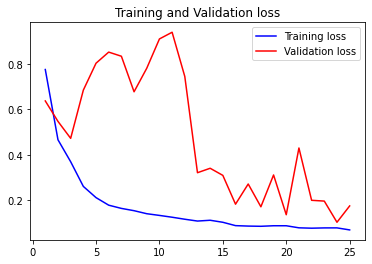

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Evaluating model accuracy by using the `evaluate` method

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
10/10 [==============================] - 0s 30ms/step - loss: 0.1755 - accuracy: 0.6000
Test Accuracy: 60.00000238418579


# Save Model

In [ ]:
print("[INFO] Saving model...")
pickle.dump(model,open('plant_disease_classification_model.pkl', 'wb'))

[INFO] Saving model...


In [ ]:
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


# Test Model


We write the following `predict_disease` function to predict the class or disease of a plant image.

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [ ]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = (model.predict(np_image) > 0.5).astype("int32")
    print((image_labels.classes_[result][0]))

For testing purposes, we randomly choose images from the dataset and try predicting class or disease of the plant image.

1/1 [==============================] - 0s 338ms/step
['Pepper__bell___Bacterial_spot' 'Pepper__bell___Bacterial_spot'
 'Pepper__bell___Bacterial_spot' 'Pepper__bell___Bacterial_spot'
 'Pepper__bell___Bacterial_spot' 'Pepper__bell___Bacterial_spot'
 'Pepper__bell___Bacterial_spot' 'Pepper__bell___Bacterial_spot'
 'Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Pepper__bell___Bacterial_spot' 'Pepper__bell___Bacterial_spot'
 'Pepper__bell___Bacterial_spot' 'Pepper__bell___Bacterial_spot'
 'Pepper__bell___Bacterial_spot']


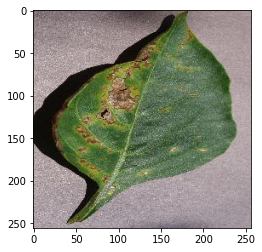

In [ ]:
predict_disease('/content/drive/MyDrive/PDD/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG')

1/1 [==============================] - 0s 71ms/step
['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Pepper__bell___Bacterial_spot' 'Pepper__bell___Bacterial_spot'
 'Pepper__bell___Bacterial_spot' 'Pepper__bell___Bacterial_spot'
 'Pepper__bell___Bacterial_spot' 'Pepper__bell___Bacterial_spot'
 'Pepper__bell___Bacterial_spot' 'Pepper__bell___Bacterial_spot'
 'Pepper__bell___Bacterial_spot' 'Pepper__bell___Bacterial_spot'
 'Pepper__bell___Bacterial_spot' 'Pepper__bell___Bacterial_spot'
 'Pepper__bell___Bacterial_spot']


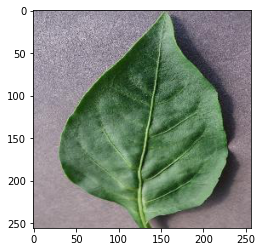

In [ ]:
predict_disease('/content/drive/MyDrive/PDD/PlantVillage/Pepper__bell___healthy/002f87b7-e1a5-49e5-a422-bb423630ded5___JR_HL 8068.JPG')

# Reuse Model

In [ ]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
#from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
filename = 'plant_disease_classification_model.pkl'
model = pickle.load(open(filename, 'rb'))

filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
DEFAULT_IMAGE_SIZE = tuple((256, 256))

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = (model.predict(np_image) > 0.5).astype("int32")
    print((image_labels.classes_[result][0]))

Prediction of diseases

1/1 [==============================] - 0s 131ms/step
['Apple___Apple_scab' 'Apple___Apple_scab' 'Apple___Apple_scab'
 'Apple___Apple_scab' 'Apple___Apple_scab' 'Apple___Apple_scab'
 'Apple___Apple_scab' 'Apple___Apple_scab' 'Apple___Apple_scab'
 'Apple___Black_rot' 'Apple___Apple_scab' 'Apple___Apple_scab'
 'Apple___Apple_scab' 'Apple___Apple_scab' 'Apple___Apple_scab']


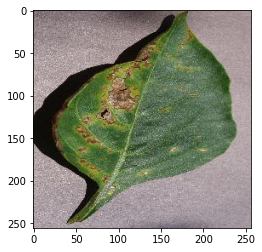

In [ ]:
predict_disease('/content/drive/MyDrive/PDD/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG')